In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

import sklearn.metrics as metrics
import torchmetrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
ex = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [4]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    def cabin_to_deck(cabin):
        if type(cabin) == str: 
            return cabin[0]
        return None
    
    df["Name"] = df["Name"].apply(normalize_name)
    #df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    #df["Ticket_item"] = df["Ticket"].apply(ticket_item) 
    df["Deck"] = df["Cabin"].apply(cabin_to_deck)

    df = pd.get_dummies(df, columns = ["Sex", "Embarked", "Deck"], drop_first=True, dtype=int)

    if "Deck_T" in df.columns: df.drop(["Deck_T"], axis=1, inplace=True) #only one observation in train.csv, none in test.csv

    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)
    #X = df.drop(["Survived"], axis=1)
    #y = df.drop(["Survived"], axis=1)
    return df
    
preprocessed_train_df = preprocess(train_data)
preprocessed_test_df = preprocess(test_data)

preprocessed_train_df.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G
0,0,3,22.0,1,0,7.2500,1,0,1,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,1,0,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,1,0,0,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,0,0,0,0,0


In [5]:
X = preprocessed_train_df.drop(["Survived"], axis=1).values
y = preprocessed_train_df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


In [6]:
steps = [("impute", SimpleImputer()), ("scale", MinMaxScaler()),]
pipeline = Pipeline(steps)
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.fit_transform(X_test)
X_val_scaled = pipeline.fit_transform(X_val)

In [7]:
trainset = TensorDataset(
    torch.tensor(X_train_scaled).float().to(device), 
    torch.tensor(y_train).float().to(device)
)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

valset = TensorDataset(
    torch.tensor(X_val_scaled).float().to(device), 
    torch.tensor(y_val).float().to(device)
)
valloader = DataLoader(valset, batch_size=32, shuffle=False)

testset = TensorDataset(
    torch.tensor(X_test_scaled).float().to(device), 
    torch.tensor(y_test).float().to(device))
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [8]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0
    preds = []
    labels = []
    for features, target in trainloader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(features).squeeze() #[32, 1] -> [32] to match with labels
        loss = criterion(output, target)
        running_loss += loss.item() * features.size(0)
        loss.backward()
        optimizer.step()

        preds += list(output.detach().cpu().numpy())
        labels += list(target.detach().cpu().numpy())

    epoch_loss = running_loss/len(trainloader.dataset)
    preds = np.where(np.array(preds) > .5, 1, 0)
    epoch_acc = metrics.accuracy_score(labels, preds)
    
    return epoch_loss, epoch_acc

def test(model, testloader, criterion):
    model.eval()
    running_loss = 0
    preds = []
    labels = []
    with torch.no_grad():
        for features, target in testloader:
            features, target = features.to(device), target.to(device)
    
            output = model(features).squeeze() #[32, 1] -> [32] to match with labels
            loss = criterion(output, target)
            running_loss += loss.item() * features.size(0)
    
            preds += list(output.detach().cpu().numpy())
            labels += list(target.detach().cpu().numpy())

    epoch_loss = running_loss/len(testloader.dataset)
    preds = np.where(np.array(preds) > .5, 1, 0)
    epoch_acc = metrics.accuracy_score(labels, preds)

    return epoch_loss, epoch_acc

In [32]:
lr = 1e-3
epochs = 500

model = nn.Sequential(
    nn.Linear(14, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    # nn.ReLU(),
    # nn.Dropout(p=0.5),
    # nn.Linear(64, 1),
)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = criterion.to(device)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

best_val_loss = float('inf')
patience = 5               # Stop after 5 epochs without improvement
counter = 0
best_model_state = None    # To save best model weights

for epoch in range(epochs):
    epoch_loss, epoch_accuracy = train(model, trainloader, criterion, optimizer)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    val_epoch_loss, val_epoch_accuracy = test(model, valloader, criterion)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Val Loss={val_epoch_loss:.4f}")

    # Early Stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_state = model.state_dict()  # Save best model weights
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Restore best model state (optional)
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# for epoch in range(epochs):
#     epoch_loss, epoch_acc = train(model, trainloader, criterion, optimizer)
    
#     print(f"-----Epoch {epoch}-----")
#     print(f"Train Loss: {epoch_loss}")
#     print(f"Train Accuracy: {epoch_acc}")
#     train_loss.append(epoch_loss)
#     train_acc.append(epoch_acc)

#     epoch_loss, epoch_acc = test(model, valloader, criterion)
    
#     print(f"Val Loss: {epoch_loss}")
#     print(f"Val Accuracy: {epoch_acc}")
#     val_loss.append(epoch_loss)
#     val_acc.append(epoch_acc)

Epoch 1: Train Loss=0.6544, Val Loss=0.6420
Epoch 2: Train Loss=0.6257, Val Loss=0.6198
Epoch 3: Train Loss=0.6049, Val Loss=0.6025
Epoch 4: Train Loss=0.5888, Val Loss=0.5856
Epoch 5: Train Loss=0.5730, Val Loss=0.5700
Epoch 6: Train Loss=0.5580, Val Loss=0.5541
Epoch 7: Train Loss=0.5432, Val Loss=0.5385
Epoch 8: Train Loss=0.5294, Val Loss=0.5247
Epoch 9: Train Loss=0.5164, Val Loss=0.5120
Epoch 10: Train Loss=0.5045, Val Loss=0.5025
Epoch 11: Train Loss=0.4957, Val Loss=0.4924
Epoch 12: Train Loss=0.4872, Val Loss=0.4855
Epoch 13: Train Loss=0.4797, Val Loss=0.4798
Epoch 14: Train Loss=0.4740, Val Loss=0.4752
Epoch 15: Train Loss=0.4691, Val Loss=0.4715
Epoch 16: Train Loss=0.4655, Val Loss=0.4687
Epoch 17: Train Loss=0.4611, Val Loss=0.4658
Epoch 18: Train Loss=0.4589, Val Loss=0.4638
Epoch 19: Train Loss=0.4548, Val Loss=0.4626
Epoch 20: Train Loss=0.4533, Val Loss=0.4607
Epoch 21: Train Loss=0.4512, Val Loss=0.4585
Epoch 22: Train Loss=0.4489, Val Loss=0.4578
Epoch 23: Train Los

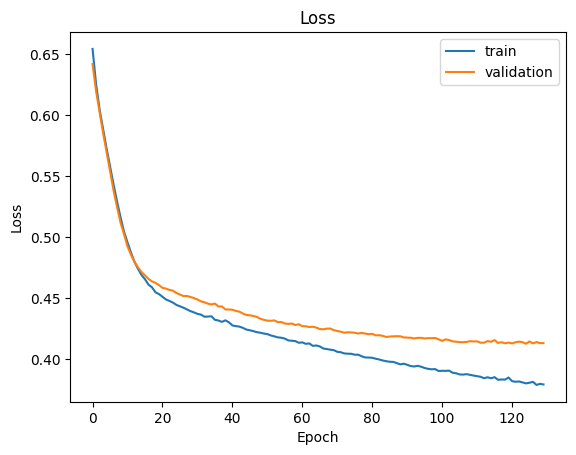

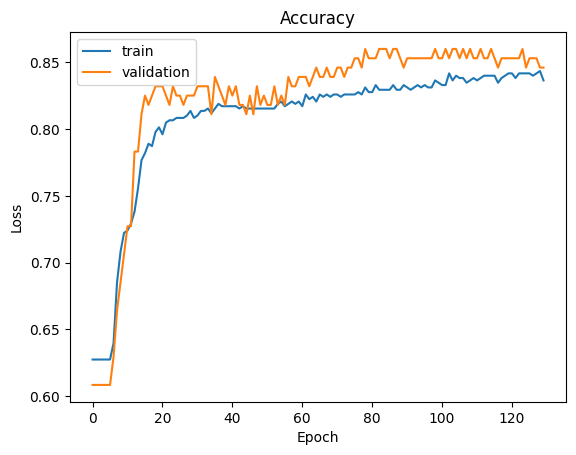

In [33]:
plt.plot(range(len(train_loss)), train_loss, label="train")
plt.plot(range(len(val_loss)), val_loss, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

plt.plot(range(len(train_loss)), train_acc, label="train")
plt.plot(range(len(val_loss)), val_acc, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy")
plt.show()

In [34]:
print(np.argmin(val_loss), train_loss[np.argmin(val_loss)], min(val_loss))
print(np.argmax(val_acc), train_acc[np.argmax(val_acc)], max(val_acc))

# print(np.argmin(train_loss), min(train_loss))

# print(np.argmax(val_acc), max(val_acc))
# print(np.argmax(train_acc), max(train_acc))

124 0.3801249381946973 0.4126405078214365
78 0.8312829525483304 0.8601398601398601


In [35]:
epoch_loss, epoch_acc = test(model, testloader, criterion)
    
print(f"Test Loss: {epoch_loss}")
print(f"Test Accuracy: {epoch_acc}")


Test Loss: 0.4233719584995142
Test Accuracy: 0.8324022346368715


In [36]:
submission_test_df = preprocess(test_data)
submission_test = pipeline.fit_transform(submission_test_df)
submissionset = TensorDataset(
    torch.tensor(submission_test).float().to(device),)
submissionloader = DataLoader(submissionset, batch_size=32, shuffle=False)

In [37]:
model.eval()
preds = []
with torch.no_grad():
    for [features] in submissionloader:
        features = features.to(device)
        output = model(features).squeeze() #[32, 1] -> [32] to match with labels
        preds += list(output.detach().cpu().numpy())

preds = np.where(np.array(preds) > .5, 1, 0)

In [38]:
submission = pd.DataFrame({"PassengerId": test_data["PassengerId"].values, "Survived": preds})
submission.to_csv("submission.csv", index=False)

In [39]:
submission.shape

(418, 2)

In [ ]:
torch.save(model.state_dict(), 'fnn_ep500_earlystop_lr1e-3.pth')

## Some data exploration

In [ ]:
preprocessed_train_df["SibSp"].value_counts()

In [ ]:
preprocessed_train_df["Ticket_number"].hist(bins=200, xrot=90, figsize=[100, 10])

In [ ]:
preprocessed_train_df["Ticket_item"].value_counts()

In [ ]:
train_data.head()

In [ ]:
train_data["Cabin"].unique()

In [ ]:
def cabin_to_deck(cabin):
    if type(cabin) == str: 
        return cabin[0]
    return None

In [ ]:
train_data["Cabin"].apply(cabin_to_deck).value_counts()

In [ ]:
train_data["Cabin"].isna().sum()